In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_csv('drive/MyDrive/EmotionTrainingDataset/Emotion_final.csv' ,nrows=4000)

df

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
3995,i feel too overwhelmed to clean anything so i ...,surprise
3996,i feel that s the one thing i ve enjoyed about...,surprise
3997,i can see in myself a lot of the older son i m...,happy
3998,i feel i can rely on my instincts more than my...,happy


In [ ]:
cat = pd.get_dummies(df.Emotion)
df = pd.concat([df, cat], axis=1)
df = df.drop(columns='Emotion')

df

,Text,anger,fear,happy,love,sadness,surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0
...,...,...,...,...,...,...,...
3995,i feel too overwhelmed to clean anything so i ...,0,0,0,0,0,1
3996,i feel that s the one thing i ve enjoyed about...,0,0,0,0,0,1
3997,i can see in myself a lot of the older son i m...,0,0,1,0,0,0
3998,i feel i can rely on my instincts more than my...,0,0,1,0,0,0


In [ ]:
emotion_text = df['Text'].values
label = df[['anger','fear','happy','love','sadness','surprise']].values

emotion_text

label

from sklearn.model_selection import train_test_split

text = df['Text'].values
y = df[['anger','fear','happy','love','sadness','surprise']].values
text_train , text_test, y_train, y_test = train_test_split(text, y, test_size=0.2)

In [ ]:
import tensorflow as tf
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=1.5e-5
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=12,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)


In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.subplot(1, 2, 1)
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.subplot(1, 2, 2)
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_history(history):
  plt.figure(figsize=(15,5))
  plot_acc(history)
  plot_loss(history)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#tokenizer
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(text_train) 
tokenizer.fit_on_texts(text_test)
 
#sequence 
seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)
 
#padding
pad_train = pad_sequences(seq_train)
pad_test = pad_sequences(seq_test)

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=20000, output_dim=64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1280000   
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 1,313,414
Trainable params: 1,313,414
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
history_emot = model.fit(
    pad_train, 
    y_train,
    epochs=100,
    callbacks = [reduce_lr, early_stop],
    verbose=1,
    validation_data=(pad_test, y_test)
)

Epoch 1/100
100/100 [==============================] - 8s 56ms/step - loss: 0.4603 - accuracy: 0.3022 - val_loss: 0.4083 - val_accuracy: 0.3300 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 5s 50ms/step - loss: 0.4151 - accuracy: 0.3347 - val_loss: 0.4073 - val_accuracy: 0.3300 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 5s 49ms/step - loss: 0.4015 - accuracy: 0.3931 - val_loss: 0.3919 - val_accuracy: 0.4575 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 5s 50ms/step - loss: 0.3446 - accuracy: 0.5419 - val_loss: 0.3465 - val_accuracy: 0.5088 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 5s 52ms/step - loss: 0.2564 - accuracy: 0.6672 - val_loss: 0.3016 - val_accuracy: 0.6162 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 5s 50ms/step - loss: 0.1858 - accuracy: 0.7834 - val_loss: 0.2883 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 5s 

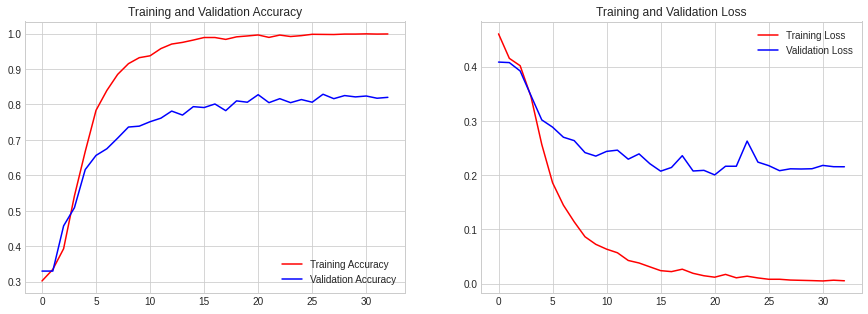

In [ ]:
plot_history(history_emot)